# Residuals Analysis


---
**License**

 Residuals Analisis

 Sun Dec 01 11:30:00 2024\
 Copyright  2024\
 Cinthia Nunes de Lima <cinthia.n.lima@uel.br> \ Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 Ascaso_Extended_Calibration\
 Copyright (C) 2024 Cinthia Nunes de Lima <cinthia.n.lima@uel.br>, Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Packages & Configs

In [ ]:
import sys
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/Scripts")


#NumCosmo
from numcosmo_py import Ncm, Nc, GObject
from richness_mass_calib import create_richness_mass_calib

#Useful packages
import numpy as np
import math
from scipy import stats
import statsmodels.api as sm


from astropy.io import fits
from astropy.table import Table
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as gridspec
from matplotlib.gridspec import GridSpec

sys.path.insert(0, "/global/homes/c/cinlima/gcrcatalogs-new/gcr-catalogs")
import GCRCatalogs

%matplotlib inline

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

sys.path.insert(0, "global/homes/c/cinlima/clevar/clevar")

#Put nerc if using nersc
GCRCatalogs.set_root_dir_by_site("nersc")

#Calibration functions
from bdata import BinningData
from fitting_model import FittingModel

## Data

In [ ]:
test_matchdata = pd.read_csv('/global/homes/c/cinlima/MatchingCatalogs/match_catalog.csv',  sep = ';')

rich_data = test_matchdata["richness"]
z_data = test_matchdata["redshift_y"]
mass_data = test_matchdata["halo_mass"]

cdc2_data = Table([mass_data, rich_data, z_data], names=('mass', 'richness', 'redshift'))


In [ ]:
mass_dt = cdc2_data['mass']
red_dt = cdc2_data['redshift']
rich_dt = cdc2_data['richness']

print(f'Mass:\t{max(mass_dt):.2e}, {min(mass_dt):.2e}')
print(f'redshift_true:\t{max(red_dt)}, {min(red_dt)}')
print(f'richness:\t{max(rich_dt)}, {min(rich_dt)}')



## Fitting

In [17]:
rmdata = create_richness_mass_calib(cdc2_data, mass_col_name = 'mass', redshift_col_name = 'redshift' )
fixed_parameters = [] 

#Quadratic
quadratic = Nc.ClusterMassLnrichExt(use_ln1pz = True)
fixed_parameters = ['A0','cut', 'cutM1', 'cutZ1'] #fixing cut parameters

quadratic.param_set_by_name("cut", 1e2) #Set cut parameter value 
mset = Ncm.MSet()
mset.set(quadratic)
rmdata.m2lnL_val(mset)  
mset.param_set_all_ftype(Ncm.ParamType.FREE) #All parameters free

#Data
dset = Ncm.Dataset.new()
dset.append_data(rmdata)
    
# Likelihood
lh = Ncm.Likelihood.new(dset)
    
# All parameters free except cut parameters:
for par in fixed_parameters:
    mset["NcClusterMass"].param_set_desc(par, {"fit": False})    
    mset.prepare_fparam_map()
    
#Fit
fit = Ncm.Fit.factory( Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL )
fit.log_info()
fit.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
fit.log_info()

# Fitted model calculated using mass and redshift from the data
quadratic_mean = np.array([quadratic.get_mean_richness(np.log(cdc2_data["mass"][i]), cdc2_data["redshift"][i]) for i in range(len(cdc2_data["mass"]))])
        
quadratic_std = np.array( [quadratic.get_std_richness(np.log(cdc2_data["mass"][i]), cdc2_data["redshift"][i]) for i in range(len(cdc2_data["mass"]))])

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  3.19                [FREE]
#   -    muM1[01]:  0.868588963806504   [FREE]
#   -    muZ1[02]: -0.304006137332276   [FREE]
#   -    muM2[03]:  0                   [FREE]
#   -    muZ2[04]:  0                   [FREE]
#   -    muMZ[05]:  0                   [FREE]
#   -  sigma0[06]:  0.33                [FREE]
#   - sigmaM1[07]: -0.0347435585522601  [FREE]
#   - sigmaZ1[08]:  0                   [FREE]
#   - sigmaM2[09]:  0                   [FREE]
#   - sigmaZ2[10]:  0                   [FREE]
#   - sigmaMZ[11]:  0                   [FREE]
#   -      A0[12]:  0                   [FIX

In [16]:
#Quadratic
linear = Nc.ClusterMassAscaso()
fixed_parameters2 = ['cut'] #fixing cut parameter
                
linear.param_set_by_name("cut", 1e2) #Set cut parameter value 
mset = Ncm.MSet()
mset.set(linear)
rmdata.m2lnL_val(mset)  
mset.param_set_all_ftype(Ncm.ParamType.FREE) #All parameters free

#Data
dset = Ncm.Dataset.new()
dset.append_data(rmdata)
    
# Likelihood
lh = Ncm.Likelihood.new(dset)
    
# All parameters free except cut parameters:
for par in fixed_parameters2:
    mset["NcClusterMass"].param_set_desc(par, {"fit": False})    
    mset.prepare_fparam_map()
    
#Fit
fit = Ncm.Fit.factory( Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL )
fit.log_info()
fit.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
fit.log_info()

# Fitted model calculated using mass and redshift from the data
linear_mean = np.array([linear.get_mean_richness(np.log(cdc2_data["mass"][i]), cdc2_data["redshift"][i]) for i in range(len(cdc2_data["mass"]))])
        
linear_std = np.array( [linear.get_std_richness(np.log(cdc2_data["mass"][i]), cdc2_data["redshift"][i]) for i in range(len(cdc2_data["mass"]))])
    

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -    mup0[00]:  3.19                [FREE]
#   -    mup1[01]:  0.868588963806504   [FREE]
#   -    mup2[02]: -0.304006137332276   [FREE]
#   - sigmap0[03]:  0.33                [FREE]
#   - sigmap1[04]: -0.0347435585522601  [FREE]
#   - sigmap2[05]:  0                   [FREE]
#   -     cut[06]:  100                 [FIXED]
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#........................................................

## Errors

Text(0.5, 1.0, 'Histogram Quadratic Model')

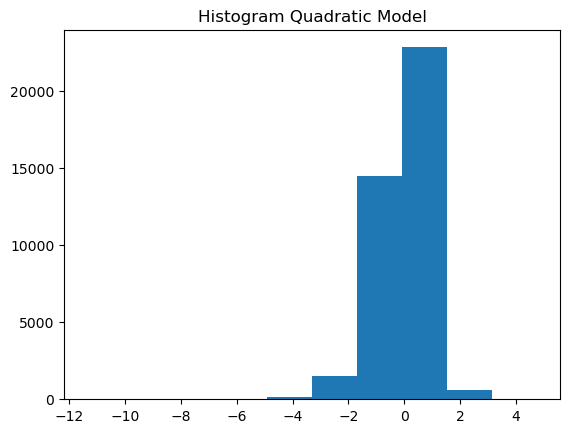

In [27]:
residuals_ext = (quadratic_mean - np.log(rich_dt)) / linear_std
residuals_asc = (linear_mean - np.log(rich_dt)) / linear_std

plt.hist(residuals_ext)
plt.title('Histogram Quadratic Model')


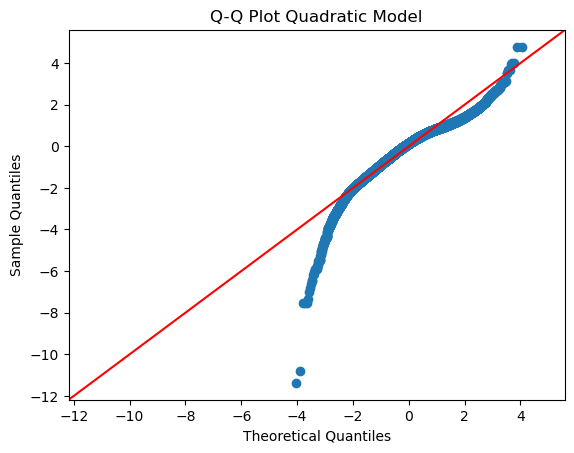

In [28]:
fig = sm.qqplot(residuals_ext, line='45')
plt.title('Q-Q Plot Quadratic Model')
plt.show()

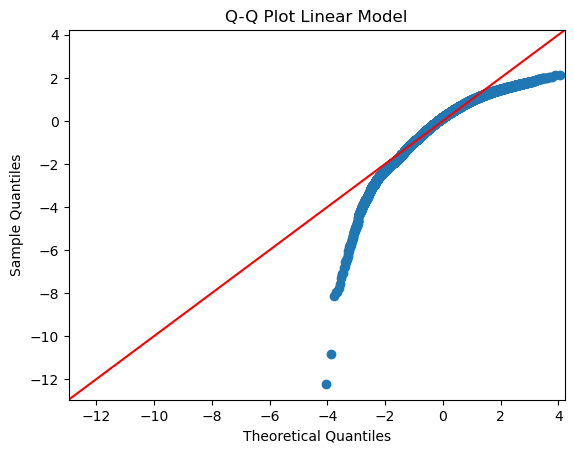

In [29]:
fig = sm.qqplot(residuals_asc, line='45')
plt.title('Q-Q Plot Linear Model')

plt.show()

Text(0, 0.5, 'Residuals')

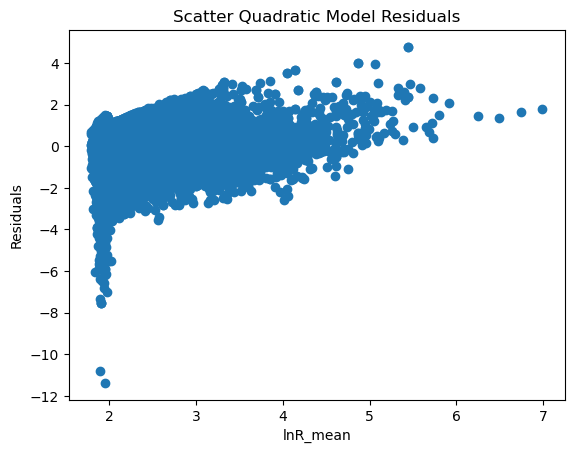

In [30]:
plt.scatter(quadratic_mean, residuals_ext)
plt.title('Scatter Quadratic Model Residuals')
plt.xlabel('lnR_mean')
plt.ylabel('Residuals')